### Il est explicité ici l'utilisation des ensembles de codes écrits pour l'analyse de sensibilité sur des champs stochastiques et variables aléatoires.

### Il est d'abord conseillé d'installer l'environnement virtuel dont la définition se trouvent dans le fichier yaml

Nous allons faire ici l'analyse de sensiblité sur une poutre en flexion représentée par 100 éléments finis, et ou le module young et le diamètre de chaque élément est déterminé par un processus gaussien en une dimension. La position de la force, sa norme, tout comme la densité du matérieau sont déterminés par des lois nomales gaussiennes.
Dans la logique d'écriture de ces codes, il faut avoir un à priori sur les processus gaussiens, la loi qu'ils suivent, tout comme sur les paramètres des lois gaussiennes. Ensuite, il faut avoir une fonction python qui prend en entrée ces champs, et qui renvoie un ensemble connu de resultas. 


In [1]:
try:
    import anastruct, openturns, numba, joblib
except:
    import os
    if os.sys.platform == 'linux' :
        file_path = 'sensitivityEnv.yml'
        os.system('conda env create -f'+file_path)
        # to have the right modules installed
        print('now activate the environment and restart jupyter with other kernel')
    else :
        print('Do it alone')

In [27]:
# Voici les deux scripts destinés à gérer l'analyse de sensibilité sur les champs stochastiques
import NdGaussianProcessSensitivity as ngps
import NdGaussianProcessConstructor as ngpc
# Classes utilitaires
import numpy                        as np
import openturns                    as ot
import matplotlib.pyplot            as plt
from   importlib                import reload 
# on importe aussi les fonctions à étudier
import RandomBeamGenerationClass    as rbgc

D'abord, nous définisson l'ensemble de nos variables d'entrée, tout comme les variables de sortie :
- L'on va définir un par un tout les processus et variables aléatoires utilisées dans notre model. Bien sûr cela implique d'avoir un à-priori sur le comportement de ces différentes lois probabilistes. 
- Néanmoins, comme nous en sommes à des codes d'essai, il serait assez trivial de rajouter la prossiblité de récuperer l'approximation d'un champ inconnu avec l'approcimation de Karhunen - Loeve, en présence d'un grand nombre de mesures.
- La définition des éléments sur lesquels est construit le champ stochastique est un peu différent de la manière interne à openturns. En effet, s'étant placés directement dans un cadre de poutre en 'éléments finis, ou l'on a N+1 noeuds (N étant le nombre de poutres), il faut savoir si N est le nombre de mailles ou le nombre de noeuds. Dans le choix a été fait ici de définir la taille du maillage (grid_shape) de la manière suivante :
> grid_shape = [[position_X0, longeur_totaleX, nombre_mailles], [position_Y0, longeur_totaleY, nombre_mailles], ..]
 

In [3]:
# process governing the young modulus for each element      (MPa)
process_E = ngpc.NdGaussianProcessConstructor(dimension=1,
                                              grid_shape=[[0,1000,100],],
                                              covariance_model={'NameModel':'MaternModel',
                                                                'amplitude':50000.,
                                                                'scale':300,
                                                                'nu':13/3},
                                              trend_arguments=['x'],trend_function=210000)
process_E.setName('E_')


# process governing the diameter for each element          (mm)
process_D = ngpc.NdGaussianProcessConstructor(dimension=1,
                                              grid_shape=[[0,1000,100],],
                                              covariance_model={'NameModel':'MaternModel',
                                                                'amplitude':.3,
                                                                'scale':250,
                                                                'nu':7.4/3},
                                              trend_arguments=['x'],trend_function=10)
process_D.setName('D_')


# random variable for the density of the material (kg/m³)
rho         = 7850.
sigma       = 750
nameD       = 'Rho'
RV_Rho = ngpc.NormalDistribution(mu = rho, sigma = sigma, name = nameD)


# random variable for the position of the force   (mm) 
middle       = 500
sigma_f      = 50
namePos     = 'FP'
RV_Fpos = ngpc.NormalDistribution(mu = middle, sigma = sigma_f, name = namePos)


# random variable for the norm of the force    (N)
muForce       = 100
# we go from sigma = 15 to sigma = 1.5, as the influence is too important
sigma_Fnor    = 5.5
nameNor       = 'FN'
RV_Fnorm = ngpc.NormalDistribution(mu = muForce, sigma = sigma_Fnor, name = nameNor)

trend function args:  ['x']  trend function:  210000 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1
trend function args:  ['x']  trend function:  10 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1


Il est important de noter que les processus et variables aléatoires doivent être définies à partir du module 
NdGaussianProcessConstructor, qui contient les classes suivantes : 
###### Classe pour construire un champ stochastique : 
> NdGaussianProcessConstructor.NdGaussianProcessConstructor() 
###### Classe pour construire une variables aléatoire  : 
> NdGaussianProcessConstructor.NormalDistribution() ## Classe openturns.Normal() suchargée
###### Classe pour construire un vecteur de variables aléatoires normales : 
> NdGaussianProcessConstructor.RandomNormalVector() ## Classe openturns.PythonRandomVector surchargée. Cette dernière est utilisée en interne par NdGaussianProcessConstructor.

**Finalement, l'autre particularité du NdGaussianProcessConstructor, est d'utiliser un objet _numpy.memmap_ modifiée, qui enregistre les échantillons de processus gaussiens sous forme de fichier temporaire dans le directoire d'utilisation des codes et les éfface en sortant du code**

L'on définit ensuite les variables de sortie. Il faut connaître l'ordre dans lequel la fonction renvoie ses resultats connaitre leur nom comme leur dimension. 
    

In [4]:
from importlib import reload
reload(ngps)
outputVariables = {'out1' :
                   {
                         'name'     : 'VonMisesStress',
                         'position' : 0,
                         'shape'    : (102,)  
                    },
                   'out2' :
                   {
                        'name'      : 'maxDeflection',
                        'position'  : 1,
                        'shape'     : (1,)
                   }
                  }
#Pour utiliser notre fonction, un wrapper a été spécialement écrit pour faciliter l'accès aux fonctions mais
#ce choix est entièrement dépendant de la manière dont a été définie la fonction sur laquelle vous travaillez.
functionWrapper = rbgc.sampleAndSoloFunctionWrapper(process_E, process_D, RV_Rho, RV_Fpos, RV_Fnorm)


###### Ensuite, on crée une instance pour l'analyse de sensibilité.
Il faut donner en entrée une liste contenant les procéssus et les variables aléatoires **dans l'ordre** dans lequel la fonction les recoit. 

*Pour cela il faut aussi connaître l'ordre des variables d'entrée de la fonction et leur nombre.*

**Ces fonctions sont celles qui prennent entrée des champs aléatoires (vecteurs et matrices, de type *list ou numpy*) et variables aléatoire (scalaires (vecteurs 1D pour le multiprocessing)) et non pas les fonctions prennant en entrée les variables aléatoires issues de la décomposition de la Karhunen Loeve, qui elles sont construites en interne dans la classe**

In [9]:
inputVarList = [process_E, process_D, RV_Rho, RV_Fpos, RV_Fnorm]
# We also the need the two functions of the model (one for samples, the other for single evaluations)
# In our case, as our model is defined as a class, we have to first create the model, 
# but it also could just be just two functions taking as an input the fields and RVs
soloFunction   = functionWrapper.randomBeamFunctionSolo
sampleFunction = functionWrapper.randomBeamFunctionSample
##
size           = 10000 ## Number of samples for our sobol indicies experiment (kept low here to make things faster)
##
reload(ngps)
##
processSensitivityAnalysis = ngps.NdGaussianProcessSensitivityAnalysis(inputVarList, 
                                                                       outputVariables,
                                                                       sampleFunction,
                                                                       soloFunction,
                                                                       size)

Input Variables are (without Karhunen Loeve Decomposition) :
 ['E_', 'D_', 'Rho', 'FP', 'FN'] 

Output Variables are :
 ['VonMisesStress', 'maxDeflection'] 

trend function args:  ['x']  trend function:  210000 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1
trend function args:  ['x']  trend function:  10 

Please be aware that the number of elements in the argument list has to be the same as the dimension of the process:  1


Voici une vue du dictionnaire intermédiaire qui est crée une fois les processus et variables aléatoires d'entrées définies :

On voit que la position des processus dans les arguments de la fonction d'entrée est enregistrée dans le dictionnaire dans la clé *position* et viennent de la manière de laquelle on a mis les VA et Processus dans le vecteur inputVarList. 


###### Ensuite, grace à l'intermédiaire de la classe ot.SobolIndiciesExperiment, on génère les' variables aléatoires d'entrée 

In [10]:
processSensitivityAnalysis.prepareSobolIndicesExperiment()


Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)
number of samples for sobol experiment =  70000 

input design is:  [[ 5.96474590e+00  6.70558955e-01  2.17007166e+00 ...  7.67145246e+03
   5.50465533e+02  1.00107314e+02]
 [ 3.69821252e+00 -6.20679489e-01  2.86342018e+00 ...  8.46696065e+03
   4.47215763e+02  1.01974431e+02]
 [ 6.47616745e+00 -8.54496972e-01  3.88259467e+00 ...  8.02050675e+03
   5.65626697e+02  9.66762805e+01]
 ...
 [ 5.89101300e+00 -9.00886265e-01  1.24730382e+00 ...  7.57293519e+03
   4.99930238e+02  9.64808612e+01]
 [ 2.71464434e+00  7.27015970e-02  3.29681205e+00 ...  7.58459365e+03
   4.29625630e+02  1.01725225e+02]
 [ 5.97706528e+00 -6.13833254e-01  2.71790214e+00 ...  7.59402869e+03
   5.21833806e+02  9.42222496e+01]]


In [11]:
########
## This is to check if we manage to regenerate missing values in the case of np.nan values
########
########
#reload(ngps)
#inputDes = np.load('inputDesign.npy',allow_pickle=True)
#inputDesNc = np.load('inputDesignNc.npy',allow_pickle=True)
#processSensitivityAnalysis = ngps.NdGaussianProcessSensitivityAnalysis(inputVarList, 
#                                                                       outputVariables,
 #                                                                      sampleFunction,
  #                                                                     soloFunction,
   #                                                                    size)
#processSensitivityAnalysis.inputDesign = inputDes
#processSensitivityAnalysis._inputDesignNC = inputDesNc
#processSensitivityAnalysis.wrappedFunction(np.array(processSensitivityAnalysis._inputDesignNC))

###### Ensuite on récupère les sorties associées aux entrées génerées. 
L'idée du postprocessing est d'identifier si dans les sorties il y a des valeurs de type np.nan, et de refaire les experiences manquantes tant qu'il y a des np.nan de présents.

**Ceci crée quelques problèmes : En effet, si le calcul numérique n'a pas pu aboutir avec une certaine réalisation des variables en entrée, est-ce que cela veut dire que cette réalisation est défaillante? Va-t-on l'inclure dans le cas du calcul de la défaillance ou de la sensibilité? Car si on l'inclut pas, il se peut qu'on oublie un nombre conséquent de modes défaillants. Solution : changer le modèle informatique et le rendre robuste à ces erreurs, ou faire une étude précise avec ces réalisation particulières.**


La solution retenue pour génerer les experiences manquantes est d'itérer au dessus de chaque index de la sortie ou se trouvent les nans, de refaire une experience de sobol de taille 1 ( donc qui renverra d+2 valeurs, avec d la dimension de l'entrée), de générer les sorties correspondant aux entrées (recommencer si il s'y trouve un np.nan), et de remplacer les d+2 valeurs du inputDesign d'entrée avec celles que l'on vient de regénérer. 

In [12]:
processSensitivityAnalysis.getOutputDesignAndPostprocess()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:   15.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done 9105 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 9240 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-1)]: Done 9377 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 9514 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 9653 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 9933 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 10074 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 10217 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 10360 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 10505 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 10650 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 10797 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 10944 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 11093 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 11242 tasks      | 

[Parallel(n_jobs=-1)]: Done 34840 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done 35105 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 35370 tasks      | elapsed: 34.5min
[Parallel(n_jobs=-1)]: Done 35637 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done 35904 tasks      | elapsed: 35.0min
[Parallel(n_jobs=-1)]: Done 36173 tasks      | elapsed: 35.3min
[Parallel(n_jobs=-1)]: Done 36442 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 36713 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 36984 tasks      | elapsed: 36.1min
[Parallel(n_jobs=-1)]: Done 37257 tasks      | elapsed: 36.4min
[Parallel(n_jobs=-1)]: Done 37530 tasks      | elapsed: 36.7min
[Parallel(n_jobs=-1)]: Done 37805 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 38080 tasks      | elapsed: 37.2min
[Parallel(n_jobs=-1)]: Done 38357 tasks      | elapsed: 37.5min
[Parallel(n_jobs=-1)]: Done 38634 tasks      | elapsed: 37.7min
[Parallel(n_jobs=-1)]: Done 38913 tasks 

shape deflection:  (70000, 103)  should be [N,10X] something
deflection std deviation  nan
timed  4113.1395154  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (70000, 102)
Element  2  has shape  (70000,)
Final shape matrix:  (70000, 103)
Columns where nan :  [  493  1543  3126  4067  6651  9051  9163 10751 11258 13272 13499 13832
 19301 19901 21258 23576 25202 26651 26653 27944 28623 28846 29051 31543
 33126 34067 36736 38623 38846 39051 40493 41543 43126 44067 46651 49051
 49163 51635 53272 53499 57907 59301 60493 61543 63126 64067 66651 69051
 69163] 

There were  49  errors (numpy.nan) while processing, trying to regenerate missing outputs 

index to change:  [  493 10493 20493 30493 40493 50493 60493]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.3074422911302734
timed  0.486930132  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1543 11543 21543 31543 41543 51543 61543]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  3.195072251723835
timed  0.540658236  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3126 13126 23126 33126 43126 53126 63126]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.4s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  5.2106578952083105
timed  0.571025372  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 4067 14067 24067 34067 44067 54067 64067]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  3.788799782003605
timed  0.501475811  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6651 16651 26651 36651 46651 56651 66651]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  4.836712112378403
timed  0.502684832  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9051 19051 29051 39051 49051 59051 69051]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.47756662242697
timed  0.574687481  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9163 19163 29163 39163 49163 59163 69163]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  4.5557481715038275
timed  0.540557623  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [  751 10751 20751 30751 40751 50751 60751]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.1098973321795775
timed  0.583763361  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1258 11258 21258 31258 41258 51258 61258]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.467147641631319
timed  0.559339285  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3272 13272 23272 33272 43272 53272 63272]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.4065494249920527
timed  0.655465841  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3499 13499 23499 33499 43499 53499 63499]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  3.688704321472631
timed  0.622265816  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3832 13832 23832 33832 43832 53832 63832]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.8478479153740108
timed  0.599391222  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9301 19301 29301 39301 49301 59301 69301]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  3.9378784684671073
timed  0.661112547  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9901 19901 29901 39901 49901 59901 69901]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  3.698897755243488
timed  0.702961206  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1258 11258 21258 31258 41258 51258 61258]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  5.068439981940554
timed  0.705978155  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3576 13576 23576 33576 43576 53576 63576]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.8081623423321118
timed  0.673711061  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 5202 15202 25202 35202 45202 55202 65202]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  6.279886684738751
timed  0.754871607  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6651 16651 26651 36651 46651 56651 66651]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.188372707969704
timed  0.786665201  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6653 16653 26653 36653 46653 56653 66653]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.6148742414691957
timed  0.740298271  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 7944 17944 27944 37944 47944 57944 67944]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.2768752793644638
timed  0.852576733  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 8623 18623 28623 38623 48623 58623 68623]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.5s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.774439643765007
timed  0.770339251  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 8846 18846 28846 38846 48846 58846 68846]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.5279801529825305
timed  0.72854805  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9051 19051 29051 39051 49051 59051 69051]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.1218846168791416
timed  0.681723118  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1543 11543 21543 31543 41543 51543 61543]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.5s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.3530071828788959
timed  0.719135284  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3126 13126 23126 33126 43126 53126 63126]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.847691134555502
timed  0.518657207  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 4067 14067 24067 34067 44067 54067 64067]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.045755945628574
timed  0.545183897  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6736 16736 26736 36736 46736 56736 66736]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.675987279072719
timed  0.548477888  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 8623 18623 28623 38623 48623 58623 68623]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  3.569217311878744
timed  0.545912504  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 8846 18846 28846 38846 48846 58846 68846]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  9.849919714248806
timed  0.584886312  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9051 19051 29051 39051 49051 59051 69051]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.5622289180584081
timed  0.590839148  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [  493 10493 20493 30493 40493 50493 60493]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  6.43470837087373
timed  0.571362257  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1543 11543 21543 31543 41543 51543 61543]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.297826698513862
timed  0.545171261  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3126 13126 23126 33126 43126 53126 63126]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  5.303950103416004
timed  0.538716316  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 4067 14067 24067 34067 44067 54067 64067]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.1915874452788682
timed  0.594536543  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6651 16651 26651 36651 46651 56651 66651]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.8561364548886914
timed  0.61063242  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9051 19051 29051 39051 49051 59051 69051]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.9871520212405751
timed  0.583303928  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9163 19163 29163 39163 49163 59163 69163]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.1633957468549734
timed  0.644307852  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1635 11635 21635 31635 41635 51635 61635]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.5149512655784982
timed  0.598986149  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3272 13272 23272 33272 43272 53272 63272]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  3.7437270012960053
timed  0.632239103  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3499 13499 23499 33499 43499 53499 63499]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.5994323118160187
timed  0.642104387  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 7907 17907 27907 37907 47907 57907 67907]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  6.444699542578375
timed  0.61366415  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9301 19301 29301 39301 49301 59301 69301]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  2.240866672539478
timed  0.694873571  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [  493 10493 20493 30493 40493 50493 60493]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  5.171896876765116
timed  0.70315671  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 1543 11543 21543 31543 41543 51543 61543]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  4.307337762019508
timed  0.648468733  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 3126 13126 23126 33126 43126 53126 63126]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.5s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  0.8649901845761718
timed  0.642683268  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 4067 14067 24067 34067 44067 54067 64067]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.6s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  5.402587612633748
timed  0.76544714  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 6651 16651 26651 36651 46651 56651 66651]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.843927606864673
timed  0.766474485  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9051 19051 29051 39051 49051 59051 69051]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.4s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.7s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  3.4911561917312817
timed  0.686915159  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
index to change:  [ 9163 19163 29163 39163 49163 59163 69163]
Generation types:
1 : Random (default)
2 : LHS
3 : LowDiscrepancySequence
4 : SimulatedAnnealingLHS
Choosen generation method is Random (default)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:    0.3s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:    0.3s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:    0.4s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:    0.6s finished


shape deflection:  (7, 103)  should be [N,10X] something
deflection std deviation  1.0364881357913986
timed  0.584495544  s for function " randomBeamFunctionSample "
Converting list of outputs into matrix: 
Element  1  has shape  (7, 102)
Element  2  has shape  (7,)
Final shape matrix:  (7, 103)
 - Post replacement assertion passed - 

Transforming matrix of shape  (70000, 103)
Into list of Ndarrays according to output definition
Dimension output  0  is  102
Intermediary shape is : (70000, 102)
new shape is:  [70000, 102]
Output element  0  has shape  (70000, 102)
Dimension output  1  is  1
Intermediary shape is : (70000, 1)
new shape is:  [70000, 1]
Output element  1  has shape  (70000,)


Le *timing* vient de la classe ***custum_wraps***, qui est pour l'instant assez inutile, mais permet de prendre en main les décorateurs...

Une fois le _output design_ generé, l'on peut faire l'analyse de sensibilité sur le model.
Pour ce faire, l'on utilise la fonction ***self.getSobolIndiciesKLCoefs***.
La fonction ne renvoie pas directement les indices de sobol, mais bien des champs d'objets ***openTURNS.SaltelliSensitivityAlgorithm*** ou ***openTURNS.MartinezSensitivityAlgorithm*** ou ***openTURNS.JansenSensitivityAlgorithm*** ou ***openTURNS.MauntzKucherenkoSensitivityAlgorithm***.

Ceci est bien sûr fait dans l'optique de toujours pouvoir accéder à l'entierté des indices de sobol et indices totaux du modèle.
Ceci veut aussi dire qu'il manque une dimension pour les champs en sortie, celle des variables d'entrée.

In [13]:
%pylab inline
pylab.rcParams['figure.figsize'] = (13, 5)
import NdGaussianProcessSensitivityIndices as ngpsi
_=reload(ngpsi)

Populating the interactive namespace from numpy and matplotlib


/home/simady/anaconda/envs/stochastic_field_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['size']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Ici on calcule les indices de sobol du premier ordre

In [14]:
output = processSensitivityAnalysis.outputDesignList; output1 = output[0]; output2 = output[1]

In [16]:
S, Stot, varS, varStot = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output1,10000)
S2, Stot2, varS2, varS2tot = ngpsi.NdGaussianProcessSensitivityIndicesBase.getSobolIndices(output2,10000)

There are 5 indices to get in (102,) dimensions with 102 elements
After centering, mean= [0.02164414 0.07706047 0.14819494 0.21991498 0.29218776 0.3652756
 0.43925892 0.51399798 0.58917759 0.66438606 0.73920775 0.81330941
 0.88650558 0.95879025 1.03033281 1.10144161 1.17250464 1.24391916
 1.31602352 1.38903949 1.46303441 1.53790718 1.61340195 1.68914596
 1.76470783 1.83966823 1.91368965 1.98657392 2.05829872 2.12902233
 2.19906043 2.26883723 2.33881728 2.40943299 2.48101664 2.55374489
 2.6274875  2.70192675 2.77635385 2.85031335 2.92270316 2.99291286
 3.05983662 3.12322877 3.1821721  3.23583239 3.28227282 3.31956502
 3.34742293 3.36420976 3.37134257 3.36897011 3.35649829 3.33541115
 3.30666012 3.27029503 3.22604636 3.17307776 3.11431475 3.05119444
 2.98501463 2.91598543 2.84461934 2.77199629 2.69874565 2.62557025
 2.55306897 2.48177725 2.41169061 2.34252401 2.27406926 2.20593186
 2.13765265 2.06880895 1.99908265 1.92830748 1.85649368 1.78382349
 1.71061596 1.63727363 1.56421244 1.49179

After centering, mean= [0.02159428 0.07689374 0.14788712 0.21947691 0.29163109 0.36461184
 0.4384994  0.51315378 0.58825927 0.66340315 0.7381682  0.81221906
 0.88536769 0.9576052  1.02909795 1.10015125 1.17115019 1.2424893
 1.31450451 1.38741546 1.46128785 1.53601943 1.6113538  1.68691834
 1.7622824  1.83702788 1.91081881 1.98345848 2.05492564 2.12537885
 2.19513303 2.26461035 2.3342721  2.40454625 2.4757598  2.54808368
 2.62132938 2.69516136 2.7689552  2.84224164 2.91371488 2.98293191
 3.0486533  3.11074827 3.16846627 3.22142623 3.26736292 3.30472438
 3.33338524 3.35115324 3.3596154  3.35831806 3.34697977 3.32722497
 3.29971063 3.26496903 3.22196315 3.1699786  3.11187939 3.04921336
 2.98349743 2.91474098 2.84384537 2.77171282 2.69887633 2.62605353
 2.55380628 2.4828017  2.41298612 2.34402094 2.27575365 2.2077994
 2.1396935  2.07100686 2.00141462 1.93074426 1.8590009  1.78636339
 1.71314937 1.6397621  1.5666201  1.49408822 1.42241882 1.35171275
 1.28190283 1.21276801 1.14396776 1.07509

The shape of the means is: [ 102 2 ]
The shape of the mean value for psi is:  (102, 2)
temporary shape after tiling (102, 2, 2)
Variance is: [0.00011873 0.00015462 0.00015619 0.00015584 0.00015539 0.00015504
 0.00015481 0.00015468 0.0001546  0.00015454 0.00015447 0.00015437
 0.00015423 0.00015406 0.00015385 0.00015361 0.00015335 0.00015309
 0.00015284 0.00015263 0.00015246 0.00015235 0.00015228 0.00015225
 0.00015224 0.00015222 0.00015218 0.00015212 0.00015204 0.00015195
 0.00015194 0.00015202 0.00015223 0.0001527  0.00015312 0.00015306
 0.00015283 0.00015365 0.00015456 0.00015604 0.00015821 0.00015996
 0.00016258 0.00016676 0.00017297 0.00018033 0.00018809 0.00019602
 0.00020399 0.00021107 0.00021344 0.00021175 0.00020758 0.00020076
 0.00019221 0.00018455 0.00017817 0.00017211 0.00016626 0.00016281
 0.00016077 0.00015849 0.00015601 0.00015464 0.00015438 0.00015462
 0.00015468 0.00015431 0.00015392 0.00015353 0.00015308 0.00015256
 0.00015199 0.00015136 0.00015066 0.0001499  0.0001491 

The shape of the means is: [ 102 2 ]
The shape of the mean value for psi is:  (102, 2)
temporary shape after tiling (102, 2, 2)
Variance is: [0.00067307 0.00055124 0.00054558 0.00054514 0.00054517 0.0005451
 0.00054486 0.00054445 0.00054395 0.00054338 0.00054277 0.00054208
 0.00054132 0.00054044 0.00053944 0.0005383  0.00053704 0.00053569
 0.00053427 0.00053283 0.00053143 0.00053011 0.00052893 0.00052792
 0.00052713 0.00052659 0.0005263  0.00052628 0.00052653 0.00052696
 0.00052821 0.0005297  0.00053141 0.00053402 0.00053645 0.00053905
 0.00054252 0.00054756 0.00055438 0.00056028 0.00056835 0.00057625
 0.00058347 0.00059254 0.00060518 0.00061827 0.00062682 0.00063859
 0.00065325 0.00066772 0.00066919 0.00066476 0.000653   0.00063807
 0.00062114 0.00060277 0.00058419 0.00056659 0.00055322 0.00054422
 0.00053622 0.0005266  0.00051869 0.00051292 0.00051106 0.00051092
 0.00051083 0.00051121 0.00051189 0.00051294 0.00051425 0.00051545
 0.00051657 0.0005175  0.00051822 0.00051871 0.00051898 

L'on peut récuperer ces indices du premier ordre dans ***self.processSensitivityAnalysis.sensitivityResults.firstOrderIndices***
Matplotlib permet de facilement visualiser ces indices. Néanmoins, cette visualisation est pour l'instant peu pertinente, puisque l'on visualise chaque variables aléatoire de Karhunen Loeve individuellement, alors qu'il nous faut encore combiner ces dernières pour que l'indice de sobol soit représentatif du champ stochastique consideré.

The output is scalar
The sensitivity is measured accordingly to the 5 input variables, namely:
 Module d'Young and Diametre and Densité and Position Force and Norme Force


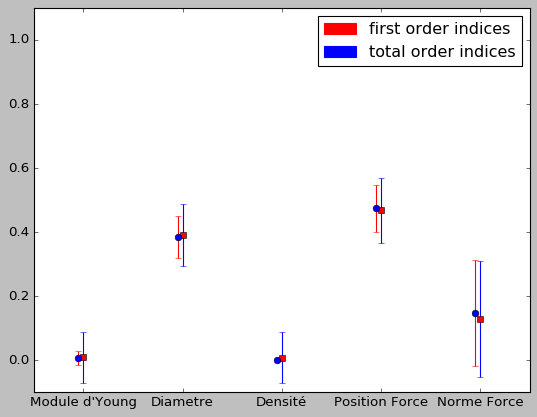

In [17]:

varNames = ["Module d'Young",'Diametre','Densité','Position Force','Norme Force']
ngpsi.plotSobolIndicesWithErr(S2, varS2, varNames, 5, Stot2, varS2tot)

The output is a vector


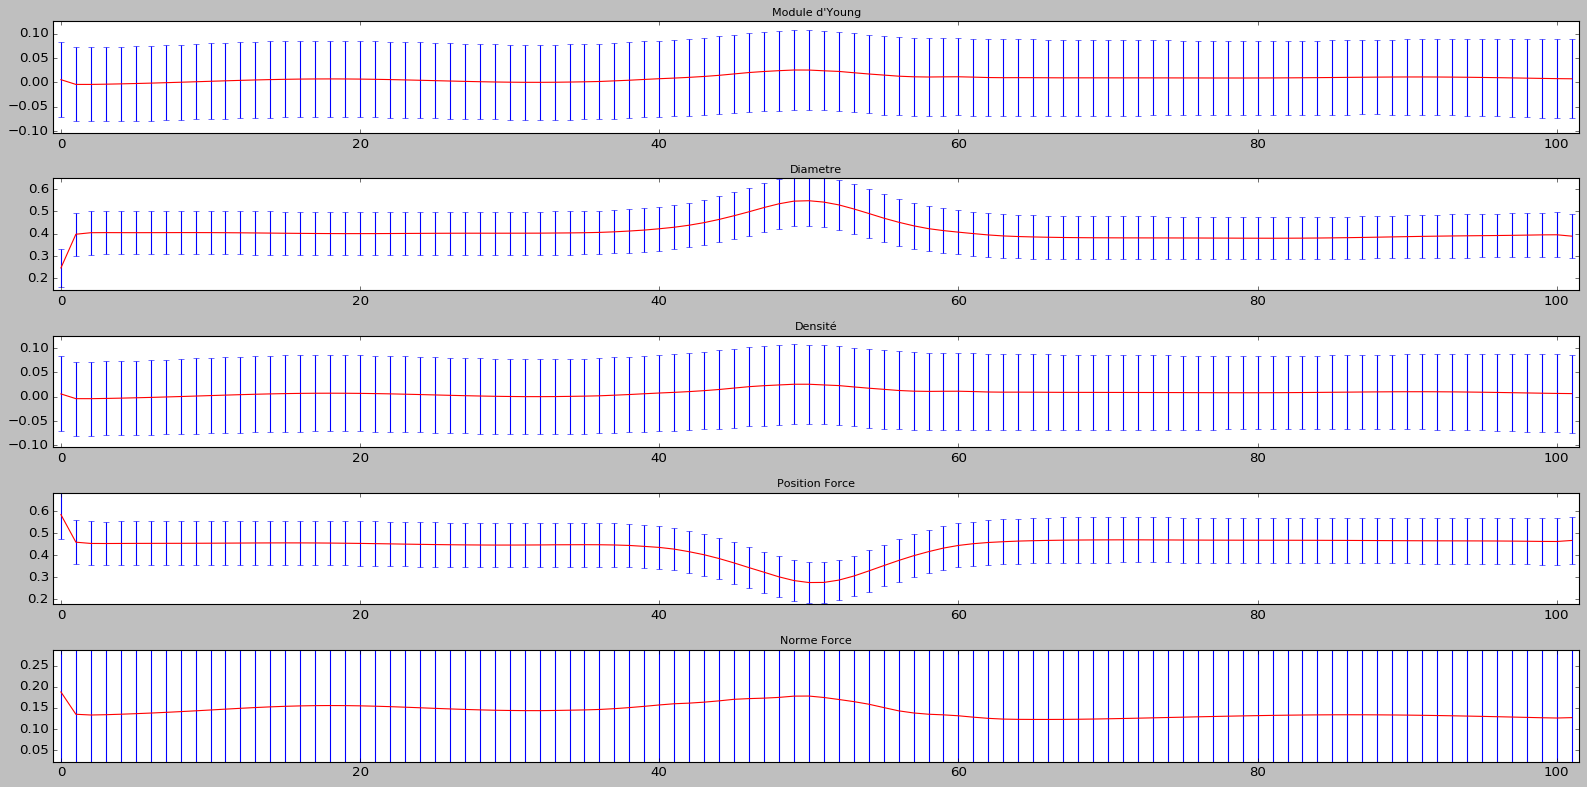

In [18]:
    ngpsi.plotSobolIndicesWithErr(S,varS, varNames, 5)

The output is a vector


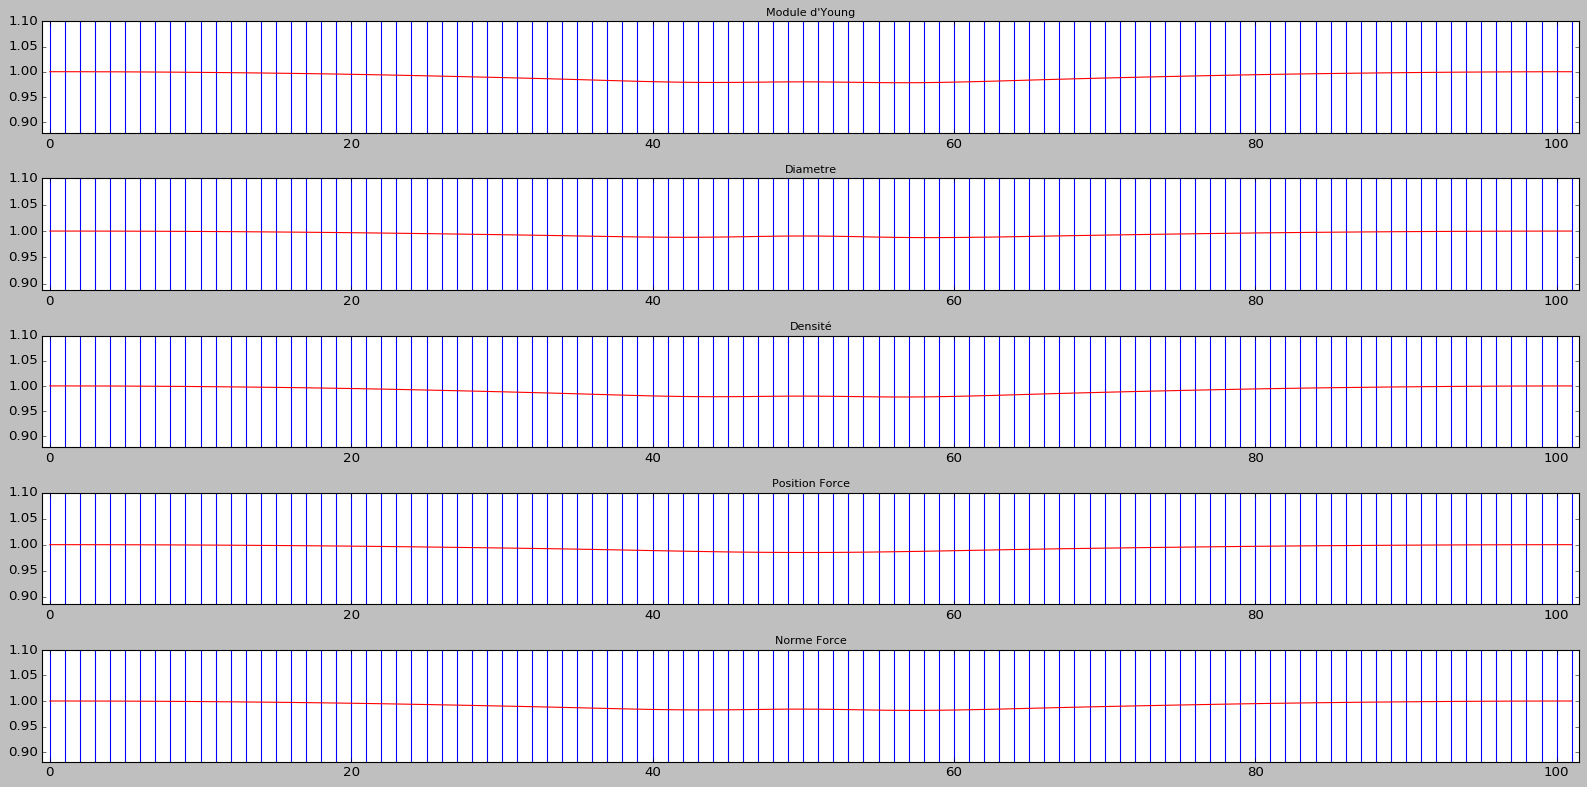

In [19]:
ngpsi.plotSobolIndicesWithErr(Stot,varStot, varNames, 5)

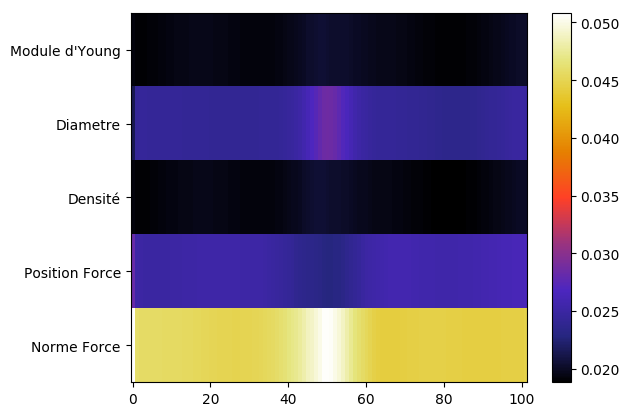

In [20]:
plt.style.use('default')
plt.yticks([0,1,2,3,4],["Module d'Young",'Diametre','Densité','Position Force','Norme Force'])
x=plt.imshow(varS, cmap='CMRmap',aspect='auto', interpolation= None)
plt.colorbar()

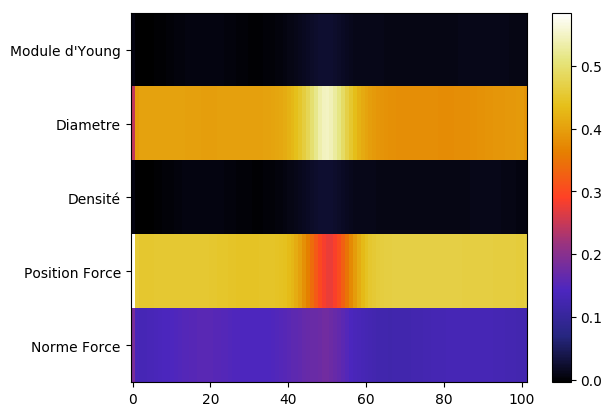

In [21]:
plt.yticks([0,1,2,3,4],["Module d'Young",'Diametre','Densité','Position Force','Norme Force'])
x=plt.imshow(S, cmap='CMRmap',aspect='auto')
plt.colorbar()

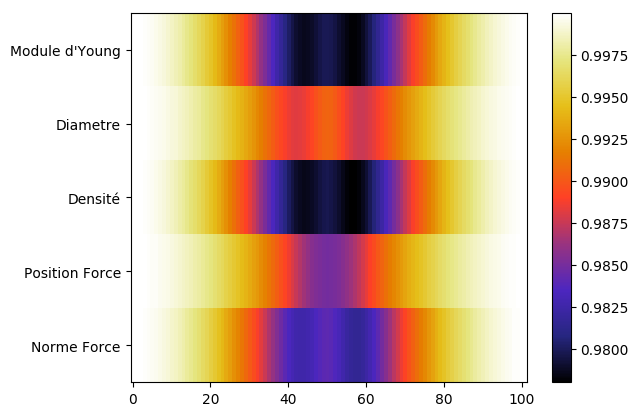

In [22]:
plt.yticks([0,1,2,3,4],["Module d'Young",'Diametre','Densité','Position Force','Norme Force'])
x=plt.imshow(Stot, cmap='CMRmap',aspect='auto')
plt.colorbar()

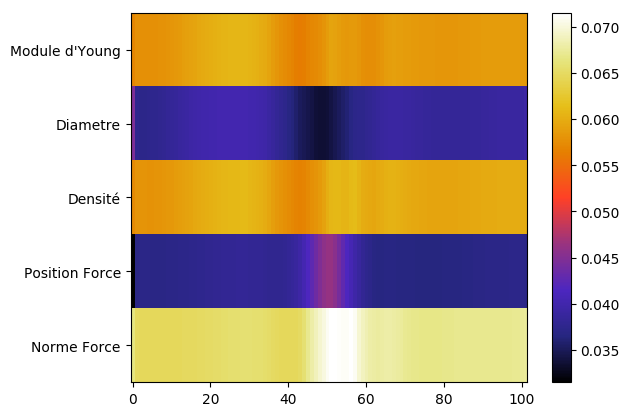

In [23]:
plt.yticks([0,1,2,3,4],["Module d'Young",'Diametre','Densité','Position Force','Norme Force'])
x=plt.imshow(varStot, cmap='CMRmap',aspect='auto')
plt.colorbar()

In [24]:
A,B = ngpsi.NdGaussianProcessSensitivityIndicesBase.SymbolicSaltelliIndices(1)
A

class=SymbolicFunction name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[X0,Y0,y0] evaluationImplementation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X0,Y0] outputVariablesNames=[y0] formulas=[(X0)/(Y0)] gradientImplementation=class=SymbolicGradient name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X0,Y0] outputVariablesNames=[y0] formulas=[(X0)/(Y0)] hessianImplementation=class=SymbolicHessian name=Unnamed evaluation=class=SymbolicEvaluation name=Unnamed inputVariablesNames=[X0,Y0] outputVariablesNames=[y0] formulas=[(X0)/(Y0)]

In [25]:
A.gradient([2,3])

class=Matrix implementation=class=MatrixImplementation name=Unnamed rows=2 columns=1 values=[0.333333,-0.222222]

In [ ]:
#composedDist = processSensitivityAnalysis.wrappedFunction.KLComposedDistribution
plt.yticks([0,1,2,3,4],["Module d'Young",'Diametre','Densité','Position Force','Norme Force'])
x=plt.imshow(S, cmap='CMRmap',aspect='auto')
plt.colorbar()

Test for the variance calculus

In [ ]:
outputDim0 = output2.shape[0];print(outputDim0)
inputDim = 5 #(5 dimensions)
N = 100
print(output2)

In [ ]:
ngpsi.NdGaussianProcessSensitivityIndicesBase.computeVariance(1, 
                                                              inputDim,
                                                             N,
                                                             output2)

In [ ]:
S_fo[...,50]

In [ ]:
im2 = plt.imshow(processSensitivityAnalysis.sensitivityResults.firstOrderIndices[1])
plt.show()

In [ ]:
#im2.write_png('sensitivity_rv_KL')

In [ ]:
processSensitivityAnalysis.wrappedFunction.getKLDecompositionVarNames

In [ ]:
np.sum(S_fo, axis=0)

In [ ]:
S_f